## Monocle3 Python

In [1]:
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
from py_monocle import learn_graph, order_cells
from py_monocle import compute_cell_states

In [2]:
ROOT_DIR = os.path.abspath("")
DATA_PATH = os.path.join(ROOT_DIR, "data", "processed_data.h5")

In [3]:
with h5py.File(DATA_PATH, "r") as f:
  umap = f["UMAP"][()]
  louvain = f["Louvain"][()]

#### Learn the trajectory graph

In [4]:
projected_points, mst, centroids = learn_graph(
  matrix=umap, clusters=louvain,
)

#### Pseudotime

In [5]:
pseudotime = order_cells(
  umap, centroids,
  mst=mst,
  projected_points=projected_points,
  root_cells=0,
)

#### Plot trajectory graph

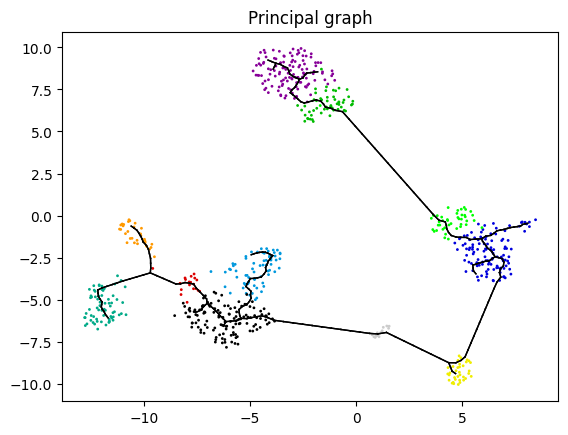

In [6]:
plt.title("Principal graph")
plt.scatter(umap[:, 0], umap[:, 1], c=louvain, s=1, cmap="nipy_spectral")

edges = np.array(mst.nonzero()).T
for edge in edges:
  plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.show()

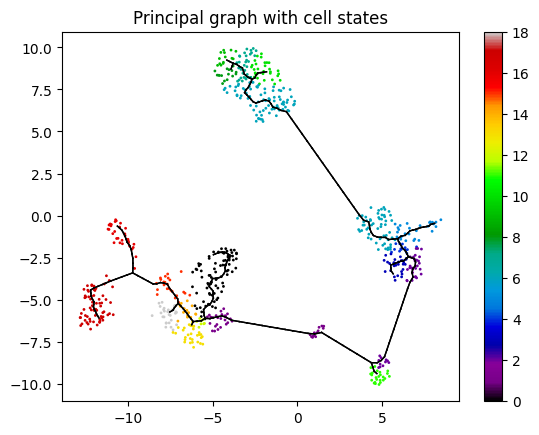

In [7]:
plt.title("Principal graph with cell states")
cell_states, _ = compute_cell_states(umap, centroids, mst)
plt.scatter(umap[:, 0], umap[:, 1], c=cell_states, s=1, cmap="nipy_spectral")
plt.colorbar()
edges = np.array(mst.nonzero()).T
for edge in edges:
  plt.plot(centroids[edge, 0], centroids[edge, 1], c="black", linewidth=1)
plt.show()

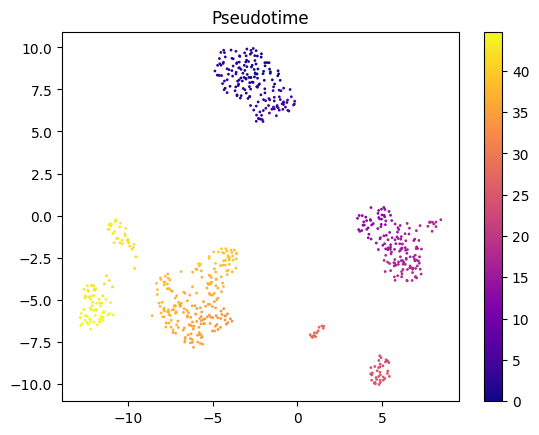

In [8]:
plt.title("Pseudotime")
plt.scatter(umap[:, 0], umap[:, 1], c=pseudotime, s=1, cmap="plasma")
plt.colorbar()
plt.show()